In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
# Data Collection
df = pd.read_csv("/content/drive/MyDrive/MSFT.csv")

In [3]:
# Data Exploration
print("Number of datapoints in the dataset:", len(df))
df

Number of datapoints in the dataset: 9083


,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400
...,...,...,...,...,...,...,...
9078,2022-03-18,295.369995,301.000000,292.730011,300.429993,300.429993,43317000
9079,2022-03-21,298.890015,300.140015,294.899994,299.160004,299.160004,28351200
9080,2022-03-22,299.799988,305.000000,298.769989,304.059998,304.059998,27599700
9081,2022-03-23,300.510010,303.230011,297.720001,299.489990,299.489990,25715400


In [4]:
print("Shape:", df.shape)
df.info()

Shape: (9083, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9083 non-null   object 
 1   Open       9083 non-null   float64
 2   High       9083 non-null   float64
 3   Low        9083 non-null   float64
 4   Close      9083 non-null   float64
 5   Adj Close  9083 non-null   float64
 6   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 496.9+ KB


In [5]:
print("Missing values in microsoft stock dataset:\n")
df.isnull().sum()

Missing values in microsoft stock dataset:



Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
print("Descriptive statistics for microsoft stock dataset:")
print(df.describe())

Descriptive statistics for microsoft stock dataset:
              Open         High          Low        Close    Adj Close  \
count  9083.000000  9083.000000  9083.000000  9083.000000  9083.000000   
mean     41.324936    41.760887    40.878488    41.335628    36.256120   
std      59.696905    60.272218    59.081728    59.714567    59.981436   
min       0.088542     0.092014     0.088542     0.090278     0.057046   
25%       4.050781     4.102051     4.027344     4.075195     2.575089   
50%      26.820000    27.100000    26.520000    26.840000    18.948530   
75%      40.034999    40.443751    39.500000    39.937500    29.244812   
max     344.619995   349.670013   342.200012   343.109985   342.402008   

             Volume  
count  9.083000e+03  
mean   5.875055e+07  
std    3.845200e+07  
min    2.304000e+06  
25%    3.461230e+07  
50%    5.203200e+07  
75%    7.265400e+07  
max    1.031789e+09  


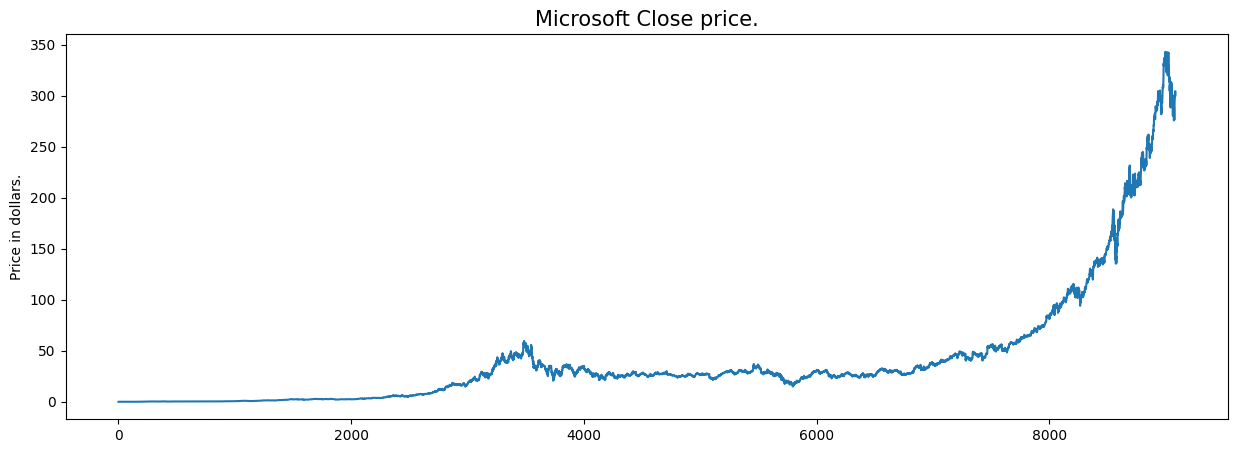

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Microsoft Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [8]:
# Data Prerocessing
output_var = pd.DataFrame(df['Adj Close'])
features = ['Open', 'High', 'Low', 'Volume']

In [9]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform

,Open,High,Low,Volume
0,0.000000,0.000027,0.000000,1.000000
1,0.000025,0.000030,0.000025,0.297096
2,0.000035,0.000032,0.000036,0.127119
3,0.000040,0.000032,0.000030,0.063588
4,0.000033,0.000025,0.000025,0.044285
...,...,...,...,...
9078,0.857052,0.860775,0.855398,0.039838
9079,0.867269,0.858315,0.861741,0.025301
9080,0.869910,0.872217,0.873053,0.024571
9081,0.871971,0.867154,0.869984,0.022741


In [10]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [11]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

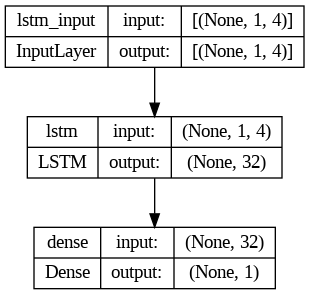

In [12]:
# Model Building
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [13]:
# Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
1033/1033 [==============================] - 11s 7ms/step - loss: 92.3709
Epoch 2/100
1033/1033 [==============================] - 7s 7ms/step - loss: 219.4362
Epoch 3/100
1033/1033 [==============================] - 7s 7ms/step - loss: 155.4186
Epoch 4/100
1033/1033 [==============================] - 5s 5ms/step - loss: 88.9138
Epoch 5/100
1033/1033 [==============================] - 3s 3ms/step - loss: 45.3541
Epoch 6/100
1033/1033 [==============================] - 3s 3ms/step - loss: 18.9357
Epoch 7/100
1033/1033 [==============================] - 3s 3ms/step - loss: 7.0379
Epoch 8/100
1033/1033 [==============================] - 5s 4ms/step - loss: 3.3588
Epoch 9/100
1033/1033 [==============================] - 3s 3ms/step - loss: 2.2417
Epoch 10/100
1033/1033 [==============================] - 3s 3ms/step - loss: 1.7037
Epoch 11/100
1033/1033 [==============================] - 3s 3ms/step - loss: 1.3774
Epoch 12/100
1033/1033 [==============================] - 3s 3ms/

In [14]:
# Model Evaluation
y_pred = lstm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

26/26 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 532.0281043098879
Mean Absolute Error (MAE): 17.683598986949573
R-squared (R2) Score: 0.8900364734358186


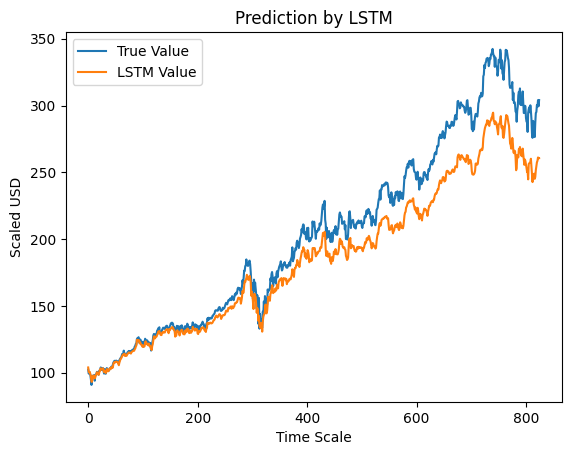

In [15]:
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()